# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:cores-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "CORES_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_44', 'ORACLE.run1_8', 'ORACLE.run1_38', 'ORACLE.run1_50', 'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_26', 'ORACLE.run1_14'}


{'CORES_4', 'CORES_2', 'CORES_1', 'CORES_5', 'CORES_3'}


tensor([[[-0.0194, -0.3495,  0.3592,  ..., -0.3301, -0.2816,  0.5631],
         [-0.5922,  0.2330, -0.1262,  ...,  0.0680, -0.9709,  0.1359]],

        [[ 0.4488, -0.7145, -1.3832,  ...,  0.4397,  0.0550, -0.3114],
         [-0.1374, -0.4030, -1.4290,  ..., -0.4672,  0.3023, -0.5130]],

        [[-0.8545, -0.4502,  0.1011,  ...,  0.1194,  1.3966,  1.0750],
         [-0.1930,  0.3308, -0.3675,  ..., -1.4793,  0.0000, -0.0276]],

        ...,

        [[-0.0124,  0.6262, -0.0744,  ..., -0.8432, -1.3578,  0.8742],
         [ 1.1904, -0.8556, -0.5270,  ..., -0.1364,  0.2046, -0.9238]],

        [[-0.8808, -1.3658, -1.6402,  ..., -0.8488,  0.5489,  0.1979],
         [ 1.1297,  0.0319,  1.1297,  ..., -0.3191,  0.7340, -0.1915]],

        [[ 1.2980, -0.6931, -0.5860,  ..., -0.7876, -0.3907, -0.0063],
         [-0.4600,  0.9704,  0.0063,  ...,  1.4997,  0.2205,  1.0460]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.5892, train_label_loss: 2.8114, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 2566.8766, train_label_loss: 1.1334, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 2479.5814, train_label_loss: 1.7792, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 2301.0382, train_label_loss: 0.6458, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 2643.5730, train_label_loss: 0.9345, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 2431.3501, train_label_loss: 0.8489, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 2552.7141, train_label_loss: 0.7120, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 2500.3512, train_label_loss: 0.5979, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 2306.4962, train_label_loss: 0.7697, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 2891.5546, train_label_loss: 1.1350, 


epoch: 1, source_val_acc_label: 0.6524, target_val_acc_label: 0.9633, source_val_label_loss: 0.9279, target_val_label_loss: 0.1728, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.8696, train_label_loss: 1.0913, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 4165.9112, train_label_loss: 0.7381, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 2914.3286, train_label_loss: 1.1617, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 2947.6614, train_label_loss: 0.5644, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3257.2647, train_label_loss: 0.5781, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 2310.3443, train_label_loss: 1.2802, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 2540.0570, train_label_loss: 1.2285, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 2578.6913, train_label_loss: 0.4720, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 2354.0314, train_label_loss: 0.3458, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 2820.9959, train_label_loss: 0.9635, 


epoch: 2, source_val_acc_label: 0.6726, target_val_acc_label: 0.9710, source_val_label_loss: 0.8613, target_val_label_loss: 0.1826, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.5902, train_label_loss: 0.5629, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 2328.5685, train_label_loss: 0.6912, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 2553.7030, train_label_loss: 0.7358, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 2544.3373, train_label_loss: 0.6088, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 2461.4932, train_label_loss: 0.4912, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 2657.5541, train_label_loss: 0.9782, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 2386.2104, train_label_loss: 1.3508, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 2659.9512, train_label_loss: 1.0619, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 2920.3889, train_label_loss: 0.5187, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3022.5462, train_label_loss: 0.8459, 


epoch: 3, source_val_acc_label: 0.7029, target_val_acc_label: 0.9769, source_val_label_loss: 0.8028, target_val_label_loss: 0.2108, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.6169, train_label_loss: 0.4374, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 2866.5336, train_label_loss: 0.4889, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 2319.9184, train_label_loss: 1.1475, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 2594.5629, train_label_loss: 0.4755, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 2696.5027, train_label_loss: 0.3906, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 2647.6476, train_label_loss: 0.6441, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3308.2128, train_label_loss: 0.3672, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 2930.9066, train_label_loss: 0.1963, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 2552.3808, train_label_loss: 0.6116, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 2418.2065, train_label_loss: 0.3860, 


epoch: 4, source_val_acc_label: 0.7206, target_val_acc_label: 0.9795, source_val_label_loss: 0.7607, target_val_label_loss: 0.2112, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.6012, train_label_loss: 0.8894, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 2624.0353, train_label_loss: 0.4342, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 2487.2806, train_label_loss: 0.2855, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 2586.6166, train_label_loss: 0.6386, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 2663.2163, train_label_loss: 0.7767, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 2711.0944, train_label_loss: 0.8048, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3169.1746, train_label_loss: 0.6943, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 2677.2164, train_label_loss: 0.6372, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 2459.0671, train_label_loss: 0.2384, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 2511.4178, train_label_loss: 0.7981, 


epoch: 5, source_val_acc_label: 0.7279, target_val_acc_label: 0.9798, source_val_label_loss: 0.7509, target_val_label_loss: 0.2113, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.5994, train_label_loss: 0.4962, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 2394.5947, train_label_loss: 0.6187, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 2792.1576, train_label_loss: 0.4414, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 2780.3089, train_label_loss: 0.4771, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3032.3621, train_label_loss: 0.2719, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 2845.0288, train_label_loss: 0.4284, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 2385.8253, train_label_loss: 0.6688, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 2577.9898, train_label_loss: 0.4264, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 2566.7143, train_label_loss: 0.5391, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 2746.4724, train_label_loss: 0.3652, 


epoch: 6, source_val_acc_label: 0.7298, target_val_acc_label: 0.9809, source_val_label_loss: 0.7451, target_val_label_loss: 0.2207, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.8872, train_label_loss: 0.6344, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3411.2006, train_label_loss: 1.1642, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 2419.6137, train_label_loss: 0.2407, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 2640.3535, train_label_loss: 0.3262, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 2452.0228, train_label_loss: 0.2213, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 2311.9963, train_label_loss: 0.5257, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 2863.9123, train_label_loss: 0.3438, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 2663.4528, train_label_loss: 0.4509, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3036.8130, train_label_loss: 0.2784, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3178.6210, train_label_loss: 0.4166, 


epoch: 7, source_val_acc_label: 0.7313, target_val_acc_label: 0.9805, source_val_label_loss: 0.7481, target_val_label_loss: 0.2319, 


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.6004, train_label_loss: 0.4035, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 2405.1659, train_label_loss: 0.2734, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 2550.1601, train_label_loss: 0.4359, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 2805.2697, train_label_loss: 0.2601, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 2824.3493, train_label_loss: 0.4891, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3072.0803, train_label_loss: 0.2831, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 2843.2794, train_label_loss: 0.2167, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 2428.8401, train_label_loss: 0.7097, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 2558.0532, train_label_loss: 0.5060, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 2551.2145, train_label_loss: 0.2968, 


epoch: 8, source_val_acc_label: 0.7329, target_val_acc_label: 0.9813, source_val_label_loss: 0.7536, target_val_label_loss: 0.2274, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.6308, train_label_loss: 0.8796, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 2787.3582, train_label_loss: 0.2652, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3270.6982, train_label_loss: 0.3481, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 2622.7904, train_label_loss: 0.3892, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 2426.7229, train_label_loss: 0.3807, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 2629.4391, train_label_loss: 0.6300, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 2321.1894, train_label_loss: 0.2690, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 2511.9472, train_label_loss: 0.3878, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 2613.7607, train_label_loss: 0.3028, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 2436.3762, train_label_loss: 0.1947, 


epoch: 9, source_val_acc_label: 0.7313, target_val_acc_label: 0.9802, source_val_label_loss: 0.7619, target_val_label_loss: 0.2426, 


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.5979, train_label_loss: 0.2487, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 2628.1245, train_label_loss: 0.3606, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 2342.3458, train_label_loss: 0.4011, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 2495.3251, train_label_loss: 0.5224, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 2698.8115, train_label_loss: 0.3592, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 2790.7818, train_label_loss: 0.3455, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3030.5302, train_label_loss: 0.9121, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 2838.9434, train_label_loss: 0.3521, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 2483.6406, train_label_loss: 0.3681, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 2434.5452, train_label_loss: 0.4994, 


epoch: 10, source_val_acc_label: 0.7307, target_val_acc_label: 0.9807, source_val_label_loss: 0.7870, target_val_label_loss: 0.2576, 


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.6149, train_label_loss: 0.1944, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3043.6968, train_label_loss: 0.3487, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3407.9230, train_label_loss: 0.4780, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3464.5428, train_label_loss: 0.4161, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 2678.3778, train_label_loss: 0.2705, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 2529.4091, train_label_loss: 0.1391, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 2522.2086, train_label_loss: 0.4855, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 2375.2527, train_label_loss: 0.5358, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 2647.7329, train_label_loss: 0.4456, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 2767.3279, train_label_loss: 0.6048, 


epoch: 11, source_val_acc_label: 0.7262, target_val_acc_label: 0.9807, source_val_label_loss: 0.8088, target_val_label_loss: 0.2690, 


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.7524, train_label_loss: 0.2643, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 2570.6677, train_label_loss: 0.2759, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 2411.6321, train_label_loss: 0.3043, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 2547.4530, train_label_loss: 0.3491, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 2438.7600, train_label_loss: 0.1224, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 2534.3764, train_label_loss: 0.4515, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 2555.3101, train_label_loss: 0.2032, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 2422.7457, train_label_loss: 0.5491, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 2498.1587, train_label_loss: 0.5165, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 2452.0867, train_label_loss: 0.9930, 


epoch: 12, source_val_acc_label: 0.7308, target_val_acc_label: 0.9816, source_val_label_loss: 0.8390, target_val_label_loss: 0.2672, 


New best


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.6711, train_label_loss: 0.7865, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 3042.7213, train_label_loss: 0.2864, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 3152.9841, train_label_loss: 0.4267, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 2561.6988, train_label_loss: 0.1983, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3284.5225, train_label_loss: 0.3647, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 3065.4893, train_label_loss: 0.5138, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 2367.9887, train_label_loss: 0.6752, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 2565.2804, train_label_loss: 0.1878, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 2473.6986, train_label_loss: 0.1529, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 2516.7113, train_label_loss: 0.0080, 


epoch: 13, source_val_acc_label: 0.7255, target_val_acc_label: 0.9806, source_val_label_loss: 0.8566, target_val_label_loss: 0.2891, 


epoch: 14, [batch: 1 / 33600], examples_per_second: 0.6015, train_label_loss: 0.3208, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 2526.7657, train_label_loss: 0.3338, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 2516.4373, train_label_loss: 0.7767, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 2836.7627, train_label_loss: 0.2785, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 2934.9513, train_label_loss: 0.2793, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 3111.5404, train_label_loss: 0.0781, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 3056.8695, train_label_loss: 0.3433, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 2914.5244, train_label_loss: 0.4024, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 3735.6250, train_label_loss: 0.2491, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 3858.9112, train_label_loss: 0.4059, 


epoch: 14, source_val_acc_label: 0.7282, target_val_acc_label: 0.9806, source_val_label_loss: 0.8763, target_val_label_loss: 0.2976, 


epoch: 15, [batch: 1 / 33600], examples_per_second: 0.6033, train_label_loss: 0.1479, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 2491.8397, train_label_loss: 0.0264, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 2304.5036, train_label_loss: 0.0391, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 2855.6683, train_label_loss: 0.6105, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 2365.2083, train_label_loss: 0.3516, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 2508.7290, train_label_loss: 0.3667, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 2595.0411, train_label_loss: 0.0285, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 2305.5087, train_label_loss: 0.3659, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 2917.9812, train_label_loss: 0.1959, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 2598.3981, train_label_loss: 0.1273, 


epoch: 15, source_val_acc_label: 0.7249, target_val_acc_label: 0.9816, source_val_label_loss: 0.8992, target_val_label_loss: 0.2985, 


New best


epoch: 16, [batch: 1 / 33600], examples_per_second: 0.7587, train_label_loss: 0.0881, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 2454.3025, train_label_loss: 0.1303, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 2584.7085, train_label_loss: 0.2506, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 2357.0518, train_label_loss: 0.2951, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 2620.8751, train_label_loss: 0.0348, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 2475.7300, train_label_loss: 0.3849, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 2445.2397, train_label_loss: 0.6210, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 2949.2068, train_label_loss: 0.1781, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 2591.3885, train_label_loss: 0.2095, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 3270.2198, train_label_loss: 0.1917, 


epoch: 16, source_val_acc_label: 0.7124, target_val_acc_label: 0.9797, source_val_label_loss: 0.9490, target_val_label_loss: 0.3343, 


epoch: 17, [batch: 1 / 33600], examples_per_second: 0.6484, train_label_loss: 0.5072, 


epoch: 17, [batch: 3360 / 33600], examples_per_second: 2472.9226, train_label_loss: 0.1256, 


epoch: 17, [batch: 6720 / 33600], examples_per_second: 2437.9324, train_label_loss: 0.1233, 


epoch: 17, [batch: 10080 / 33600], examples_per_second: 2494.8611, train_label_loss: 0.2046, 


epoch: 17, [batch: 13440 / 33600], examples_per_second: 2489.4394, train_label_loss: 0.0808, 


epoch: 17, [batch: 16800 / 33600], examples_per_second: 2768.6619, train_label_loss: 0.1795, 


epoch: 17, [batch: 20160 / 33600], examples_per_second: 2711.0569, train_label_loss: 0.2077, 


epoch: 17, [batch: 23520 / 33600], examples_per_second: 2963.6157, train_label_loss: 0.2549, 


epoch: 17, [batch: 26880 / 33600], examples_per_second: 3153.2830, train_label_loss: 0.1979, 


epoch: 17, [batch: 30240 / 33600], examples_per_second: 2600.6509, train_label_loss: 0.0658, 


epoch: 17, source_val_acc_label: 0.7227, target_val_acc_label: 0.9815, source_val_label_loss: 0.9605, target_val_label_loss: 0.3281, 


epoch: 18, [batch: 1 / 33600], examples_per_second: 0.6513, train_label_loss: 0.0831, 


epoch: 18, [batch: 3360 / 33600], examples_per_second: 3406.6649, train_label_loss: 0.1747, 


epoch: 18, [batch: 6720 / 33600], examples_per_second: 4050.9827, train_label_loss: 0.2783, 


epoch: 18, [batch: 10080 / 33600], examples_per_second: 3142.9740, train_label_loss: 0.2949, 


epoch: 18, [batch: 13440 / 33600], examples_per_second: 2588.0438, train_label_loss: 0.1985, 


epoch: 18, [batch: 16800 / 33600], examples_per_second: 2523.9401, train_label_loss: 0.0870, 


epoch: 18, [batch: 20160 / 33600], examples_per_second: 2482.8937, train_label_loss: 0.1988, 


epoch: 18, [batch: 23520 / 33600], examples_per_second: 2537.2496, train_label_loss: 0.2934, 


epoch: 18, [batch: 26880 / 33600], examples_per_second: 2405.3298, train_label_loss: 0.3929, 


epoch: 18, [batch: 30240 / 33600], examples_per_second: 2589.5362, train_label_loss: 0.2796, 


epoch: 18, source_val_acc_label: 0.7206, target_val_acc_label: 0.9810, source_val_label_loss: 0.9766, target_val_label_loss: 0.3284, 


epoch: 19, [batch: 1 / 33600], examples_per_second: 0.5972, train_label_loss: 0.2024, 


epoch: 19, [batch: 3360 / 33600], examples_per_second: 2482.7698, train_label_loss: 0.0619, 


epoch: 19, [batch: 6720 / 33600], examples_per_second: 2521.1448, train_label_loss: 0.2627, 


epoch: 19, [batch: 10080 / 33600], examples_per_second: 2567.9167, train_label_loss: 0.0597, 


epoch: 19, [batch: 13440 / 33600], examples_per_second: 2393.1356, train_label_loss: 0.1029, 


epoch: 19, [batch: 16800 / 33600], examples_per_second: 2795.2140, train_label_loss: 0.1425, 


epoch: 19, [batch: 20160 / 33600], examples_per_second: 2815.1851, train_label_loss: 0.2559, 


epoch: 19, [batch: 23520 / 33600], examples_per_second: 2843.0646, train_label_loss: 0.2725, 


epoch: 19, [batch: 26880 / 33600], examples_per_second: 3069.7393, train_label_loss: 0.1420, 


epoch: 19, [batch: 30240 / 33600], examples_per_second: 2397.8932, train_label_loss: 0.1017, 


epoch: 19, source_val_acc_label: 0.7188, target_val_acc_label: 0.9804, source_val_label_loss: 1.0124, target_val_label_loss: 0.3702, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

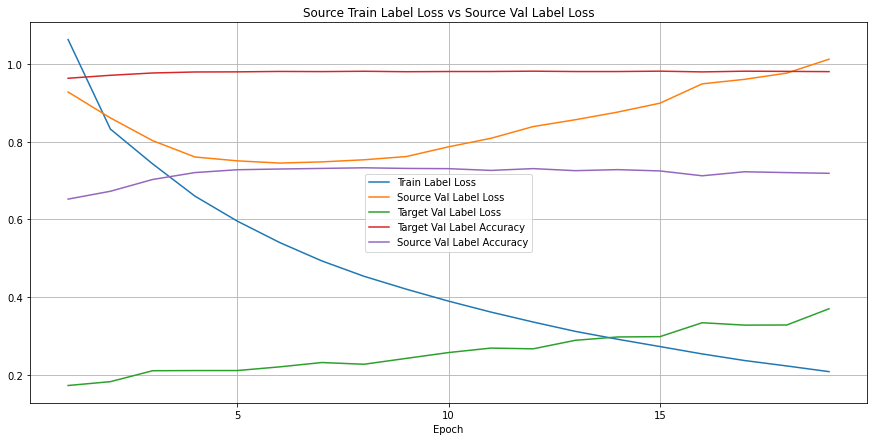

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

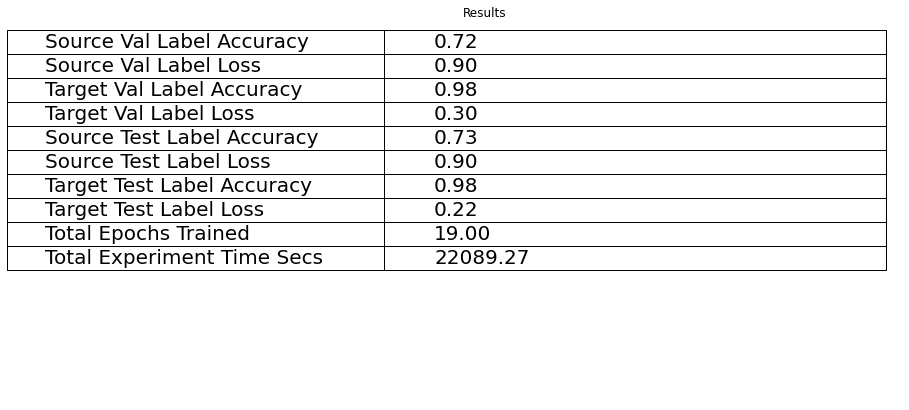

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

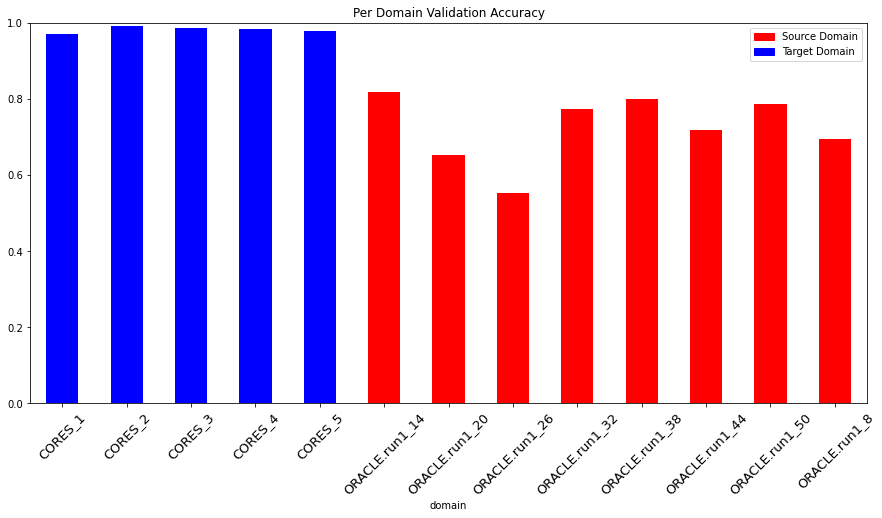

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7251302083333333 Target Test Label Accuracy: 0.9834806397306397
Source Val Label Accuracy: 0.72486328125 Target Val Label Accuracy: 0.9815924657534246


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:cores-oracle.run1", "parameters": {"experiment_name": "tl_1v2:cores-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL